In [49]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [50]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('the_call_of_cthulhu.txt', sep='/n', header=None)
df.head()

<ipython-input-50-f6e77ae22c8d>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('the_call_of_cthulhu.txt', sep='/n', header=None)


,0
0,'THE CALL OF CTHULHU By H.P. LOVECRAFT THE CAL...


In [51]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [52]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from tensorflow.keras.preprocessing.sequence import pad_sequences

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [53]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'\'THE CALL OF CTHULHU By H.P. LOVECRAFT THE CALL OF CTHULHU Of such great powers or beings there may be conceivably a survival... a survival of a hugely remote period when... consciousness was manifested, perhaps, in shapes and forms long since withdrawn before the tide of advancing humanity... forms of which poetry and legend alone have caught a flying memory and called them gods, monsters, mythical beings of all sorts and kinds... — Algernon Blackwood PART I. THE HORROR IN CLAY The most merciful thing in the world, I think, is the inability of the human mind to correlate all its contents. We live on a placid island of ignorance in the midst of black seas of infinity, and it was not meant that we should voyage far. The sciences, each straining in its own direction, have hitherto harmed us little; but some day the piecing together of dissociated knowledge will open up such terrifying vistas of reality, and of our frightful position therein, that we shall either go mad from the revelat

In [54]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

["'the",
 'call',
 'of',
 'cthulhu',
 'by',
 'h',
 'p',
 'lovecraft',
 'the',
 'call',
 'of',
 'cthulhu',
 'of',
 'such',
 'great',
 'powers',
 'or',
 'beings',
 'there',
 'may',
 'be',
 'conceivably',
 'a',
 'survival',
 'a',
 'survival',
 'of',
 'a',
 'hugely',
 'remote',
 'period',
 'when',
 'consciousness',
 'was',
 'manifested',
 'perhaps',
 'in',
 'shapes',
 'and',
 'forms',
 'long',
 'since',
 'withdrawn',
 'before',
 'the',
 'tide',
 'of',
 'advancing',
 'humanity',
 'forms',
 'of',
 'which',
 'poetry',
 'and',
 'legend',
 'alone',
 'have',
 'caught',
 'a',
 'flying',
 'memory',
 'and',
 'called',
 'them',
 'gods',
 'monsters',
 'mythical',
 'beings',
 'of',
 'all',
 'sorts',
 'and',
 'kinds',
 '—',
 'algernon',
 'blackwood',
 'part',
 'i',
 'the',
 'horror',
 'in',
 'clay',
 'the',
 'most',
 'merciful',
 'thing',
 'in',
 'the',
 'world',
 'i',
 'think',
 'is',
 'the',
 'inability',
 'of',
 'the',
 'human',
 'mind',
 'to',
 'correlate',
 'all',
 'its',
 'contents',
 'we',
 'liv

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [55]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [56]:
# Demos un vistazo
sentence_tokens[:2]

[["'the",
  'call',
  'of',
  'cthulhu',
  'by',
  'h',
  'p',
  'lovecraft',
  'the',
  'call',
  'of',
  'cthulhu',
  'of',
  'such',
  'great',
  'powers',
  'or',
  'beings',
  'there',
  'may',
  'be',
  'conceivably',
  'a',
  'survival',
  'a',
  'survival',
  'of',
  'a',
  'hugely',
  'remote',
  'period',
  'when',
  'consciousness',
  'was',
  'manifested',
  'perhaps',
  'in',
  'shapes',
  'and',
  'forms',
  'long',
  'since',
  'withdrawn',
  'before',
  'the',
  'tide',
  'of',
  'advancing',
  'humanity',
  'forms',
  'of',
  'which',
  'poetry',
  'and',
  'legend',
  'alone',
  'have',
  'caught',
  'a',
  'flying',
  'memory',
  'and',
  'called',
  'them',
  'gods',
  'monsters',
  'mythical',
  'beings',
  'of',
  'all',
  'sorts',
  'and',
  'kinds',
  '—',
  'algernon',
  'blackwood',
  'part',
  'i',
  'the',
  'horror',
  'in',
  'clay',
  'the',
  'most',
  'merciful',
  'thing',
  'in',
  'the',
  'world',
  'i',
  'think',
  'is',
  'the',
  'inability',
  

In [57]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [58]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences

[["'the", 'call', 'of', 'cthulhu'],
 ['call', 'of', 'cthulhu', 'by'],
 ['of', 'cthulhu', 'by', 'h'],
 ['cthulhu', 'by', 'h', 'p'],
 ['by', 'h', 'p', 'lovecraft'],
 ['h', 'p', 'lovecraft', 'the'],
 ['p', 'lovecraft', 'the', 'call'],
 ['lovecraft', 'the', 'call', 'of'],
 ['the', 'call', 'of', 'cthulhu'],
 ['call', 'of', 'cthulhu', 'of'],
 ['of', 'cthulhu', 'of', 'such'],
 ['cthulhu', 'of', 'such', 'great'],
 ['of', 'such', 'great', 'powers'],
 ['such', 'great', 'powers', 'or'],
 ['great', 'powers', 'or', 'beings'],
 ['powers', 'or', 'beings', 'there'],
 ['or', 'beings', 'there', 'may'],
 ['beings', 'there', 'may', 'be'],
 ['there', 'may', 'be', 'conceivably'],
 ['may', 'be', 'conceivably', 'a'],
 ['be', 'conceivably', 'a', 'survival'],
 ['conceivably', 'a', 'survival', 'a'],
 ['a', 'survival', 'a', 'survival'],
 ['survival', 'a', 'survival', 'of'],
 ['a', 'survival', 'of', 'a'],
 ['survival', 'of', 'a', 'hugely'],
 ['of', 'a', 'hugely', 'remote'],
 ['a', 'hugely', 'remote', 'period'],
 [

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [59]:
tok = Tokenizer()

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [60]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[3155, 454, 2, 58],
 [454, 2, 58, 21],
 [2, 58, 21, 682],
 [58, 21, 682, 683],
 [21, 682, 683, 1201],
 [682, 683, 1201, 1],
 [683, 1201, 1, 454],
 [1201, 1, 454, 2],
 [1, 454, 2, 58],
 [454, 2, 58, 2],
 [2, 58, 2, 135],
 [58, 2, 135, 44],
 [2, 135, 44, 1202],
 [135, 44, 1202, 32],
 [44, 1202, 32, 684],
 [1202, 32, 684, 42],
 [32, 684, 42, 136],
 [684, 42, 136, 30],
 [42, 136, 30, 1203],
 [136, 30, 1203, 4],
 [30, 1203, 4, 685],
 [1203, 4, 685, 4],
 [4, 685, 4, 685],
 [685, 4, 685, 2],
 [4, 685, 2, 4],
 [685, 2, 4, 1204],
 [2, 4, 1204, 686],
 [4, 1204, 686, 259],
 [1204, 686, 259, 51],
 [686, 259, 51, 687],
 [259, 51, 687, 7],
 [51, 687, 7, 688],
 [687, 7, 688, 455],
 [7, 688, 455, 5],
 [688, 455, 5, 456],
 [455, 5, 456, 3],
 [5, 456, 3, 689],
 [456, 3, 689, 137],
 [3, 689, 137, 210],
 [689, 137, 210, 1205],
 [137, 210, 1205, 67],
 [210, 1205, 67, 1],
 [1205, 67, 1, 1206],
 [67, 1, 1206, 2],
 [1, 1206, 2, 1207],
 [1206, 2, 1207, 1208],
 [2, 1207, 1208, 689],
 [1207, 1208, 689, 2],
 [12

In [61]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

12011


In [62]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

3156


In [63]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'of': 2, 'and': 3, 'a': 4, 'in': 5, 'to': 6, 'was': 7, 'had': 8, 'that': 9, 'i': 10, 'it': 11, 'he': 12, 'his': 13, 'which': 14, 'with': 15, 'from': 16, 'for': 17, 'on': 18, 'at': 19, 'as': 20, 'by': 21, 'but': 22, "'s": 23, 'not': 24, 'this': 25, 'my': 26, 'were': 27, 'all': 28, 'an': 29, 'be': 30, 'they': 31, 'or': 32, 'have': 33, 'its': 34, 'some': 35, 'could': 36, 'one': 37, 'no': 38, 'cult': 39, 'their': 40, 'men': 41, 'there': 42, 'what': 43, 'great': 44, 'professor': 45, 'so': 46, 'them': 47, 'old': 48, 'been': 49, 'only': 50, 'when': 51, 'him': 52, 'is': 53, 'would': 54, 'uncle': 55, 'now': 56, 'johansen': 57, 'cthulhu': 58, 'more': 59, 'dreams': 60, 'after': 61, 'man': 62, 'then': 63, 'wilcox': 64, 'out': 65, 'legrasse': 66, 'before': 67, 'me': 68, 'found': 69, 'thing': 70, 'who': 71, 'than': 72, 'told': 73, 'time': 74, 'very': 75, 'strange': 76, 'like': 77, 'dream': 78, 'earth': 79, 'into': 80, 'came': 81, 'must': 82, 'stone': 83, 'up': 84, 'never': 85, 'said': 86,

In [64]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {"'the": 1, 'of': 2098, 'cthulhu': 98, 'call': 14, 'by': 272, 'h': 8, 'p': 8, 'lovecraft': 4, 'the': 3112, 'such': 40, 'great': 128, 'powers': 4, 'or': 160, 'beings': 8, 'there': 132, 'may': 40, 'be': 172, 'conceivably': 4, 'a': 961, 'survival': 6, 'hugely': 4, 'remote': 8, 'period': 20, 'when': 120, 'consciousness': 8, 'was': 684, 'manifested': 8, 'perhaps': 12, 'in': 870, 'shapes': 12, 'and': 1892, 'forms': 8, 'long': 40, 'since': 24, 'withdrawn': 4, 'before': 86, 'tide': 4, 'advancing': 4, 'humanity': 4, 'which': 376, 'poetry': 8, 'legend': 8, 'alone': 28, 'have': 152, 'caught': 8, 'flying': 4, 'memory': 20, 'called': 20, 'them': 124, 'gods': 8, 'monsters': 4, 'mythical': 4, 'all': 188, 'sorts': 4, 'kinds': 4, '—': 8, 'algernon': 4, 'blackwood': 4, 'part': 48, 'i': 448, 'horror': 28, 'clay': 16, 'most': 32, 'merciful': 4, 'thing': 84, 'world': 50, 'think': 44, 'is': 112, 'inability': 4, 'human': 20, 'mind': 24, 'to': 802, 'correlate': 4, 'its': 152, 'conte

### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [65]:
# Vistazo a las primeras filas
df.loc[:15,0]

0    'THE CALL OF CTHULHU By H.P. LOVECRAFT THE CAL...
Name: 0, dtype: object

In [66]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'\'THE CALL OF CTHULHU By H.P. LOVECRAFT THE CALL OF CTHULHU Of such great powers or beings there may be conceivably a survival... a survival of a hugely remote period when... consciousness was manifested, perhaps, in shapes and forms long since withdrawn before the tide of advancing humanity... forms of which poetry and legend alone have caught a flying memory and called them gods, monsters, mythical beings of all sorts and kinds... — Algernon Blackwood PART I. THE HORROR IN CLAY The most merciful thing in the world, I think, is the inability of the human mind to correlate all its contents. We live on a placid island of ignorance in the midst of black seas of infinity, and it was not meant that we should voyage far. The sciences, each straining in its own direction, have hitherto harmed us little; but some day the piecing together of dissociated knowledge will open up such terrifying vistas of reality, and of our frightful position therein, that we shall either go mad from the revelat

In [67]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

["'the",
 'call',
 'of',
 'cthulhu',
 'by',
 'h',
 'p',
 'lovecraft',
 'the',
 'call',
 'of',
 'cthulhu',
 'of',
 'such',
 'great',
 'powers',
 'or',
 'beings',
 'there',
 'may']

In [68]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 12015


In [69]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [70]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[["'the", 'call', 'of', 'cthulhu'],
 ['call', 'of', 'cthulhu', 'by'],
 ['of', 'cthulhu', 'by', 'h'],
 ['cthulhu', 'by', 'h', 'p'],
 ['by', 'h', 'p', 'lovecraft'],
 ['h', 'p', 'lovecraft', 'the'],
 ['p', 'lovecraft', 'the', 'call'],
 ['lovecraft', 'the', 'call', 'of'],
 ['the', 'call', 'of', 'cthulhu'],
 ['call', 'of', 'cthulhu', 'of'],
 ['of', 'cthulhu', 'of', 'such'],
 ['cthulhu', 'of', 'such', 'great'],
 ['of', 'such', 'great', 'powers'],
 ['such', 'great', 'powers', 'or'],
 ['great', 'powers', 'or', 'beings'],
 ['powers', 'or', 'beings', 'there'],
 ['or', 'beings', 'there', 'may'],
 ['beings', 'there', 'may', 'be'],
 ['there', 'may', 'be', 'conceivably'],
 ['may', 'be', 'conceivably', 'a']]

In [71]:
# Proceso de tokenizacion
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[3155, 454, 2, 58],
 [454, 2, 58, 21],
 [2, 58, 21, 682],
 [58, 21, 682, 683],
 [21, 682, 683, 1201],
 [682, 683, 1201, 1],
 [683, 1201, 1, 454],
 [1201, 1, 454, 2],
 [1, 454, 2, 58],
 [454, 2, 58, 2],
 [2, 58, 2, 135],
 [58, 2, 135, 44],
 [2, 135, 44, 1202],
 [135, 44, 1202, 32],
 [44, 1202, 32, 684],
 [1202, 32, 684, 42],
 [32, 684, 42, 136],
 [684, 42, 136, 30],
 [42, 136, 30, 1203],
 [136, 30, 1203, 4]]

In [72]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 12011


### 3 - Input y target

In [73]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [74]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [75]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [76]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(12011, 3)
(12011,)


In [77]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'of',
 3: 'and',
 4: 'a',
 5: 'in',
 6: 'to',
 7: 'was',
 8: 'had',
 9: 'that',
 10: 'i',
 11: 'it',
 12: 'he',
 13: 'his',
 14: 'which',
 15: 'with',
 16: 'from',
 17: 'for',
 18: 'on',
 19: 'at',
 20: 'as',
 21: 'by',
 22: 'but',
 23: "'s",
 24: 'not',
 25: 'this',
 26: 'my',
 27: 'were',
 28: 'all',
 29: 'an',
 30: 'be',
 31: 'they',
 32: 'or',
 33: 'have',
 34: 'its',
 35: 'some',
 36: 'could',
 37: 'one',
 38: 'no',
 39: 'cult',
 40: 'their',
 41: 'men',
 42: 'there',
 43: 'what',
 44: 'great',
 45: 'professor',
 46: 'so',
 47: 'them',
 48: 'old',
 49: 'been',
 50: 'only',
 51: 'when',
 52: 'him',
 53: 'is',
 54: 'would',
 55: 'uncle',
 56: 'now',
 57: 'johansen',
 58: 'cthulhu',
 59: 'more',
 60: 'dreams',
 61: 'after',
 62: 'man',
 63: 'then',
 64: 'wilcox',
 65: 'out',
 66: 'legrasse',
 67: 'before',
 68: 'me',
 69: 'found',
 70: 'thing',
 71: 'who',
 72: 'than',
 73: 'told',
 74: 'time',
 75: 'very',
 76: 'strange',
 77: 'like',
 78: 'dream',
 79: 'earth',
 80: 

In [78]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)

In [79]:
# Transformar los datos a oneHotEncoding
#y_data = to_categorical(y_data_int, num_classes=vocab_size)

In [80]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [81]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)
y_data.shape

(12011, 3156)

### 4 - Entrenar el modelo

In [82]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1]
input_seq_len

3

In [83]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

3156

In [84]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

#model.add(LSTM(64, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 5)              15785     
                                                                 
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 3156)              104148    
                                                                 
Total params: 139,933
Trainable params: 139,933
Non-trainable params: 0
_________________________________________________________________


In [85]:
hist = model.fit(x_data, y_data, epochs=750, validation_split=0.2)

Epoch 1/750
301/301 [==============================] - 14s 35ms/step - loss: 7.0602 - accuracy: 0.0598 - val_loss: 6.9834 - val_accuracy: 0.0753
Epoch 2/750
301/301 [==============================] - 3s 11ms/step - loss: 6.4947 - accuracy: 0.0645 - val_loss: 7.1273 - val_accuracy: 0.0753
Epoch 3/750
301/301 [==============================] - 3s 11ms/step - loss: 6.3940 - accuracy: 0.0645 - val_loss: 7.2167 - val_accuracy: 0.0753
Epoch 4/750
301/301 [==============================] - 3s 10ms/step - loss: 6.2663 - accuracy: 0.0645 - val_loss: 7.3574 - val_accuracy: 0.0753
Epoch 5/750
301/301 [==============================] - 2s 8ms/step - loss: 6.1587 - accuracy: 0.0645 - val_loss: 7.4416 - val_accuracy: 0.0753
Epoch 6/750
301/301 [==============================] - 3s 9ms/step - loss: 6.0745 - accuracy: 0.0703 - val_loss: 7.7186 - val_accuracy: 0.0757
Epoch 7/750
301/301 [==============================] - 2s 8ms/step - loss: 5.9975 - accuracy: 0.0768 - val_loss: 7.7366 - val_accuracy: 0

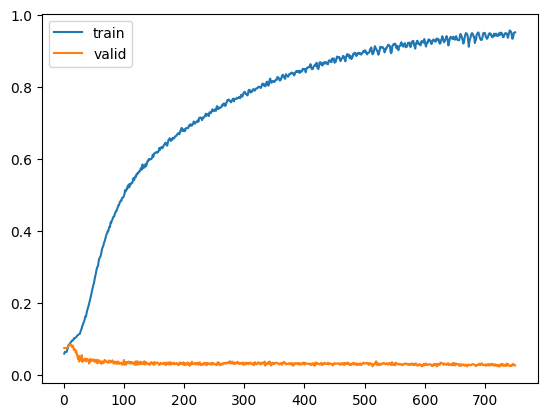

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [87]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [88]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

### 6 - Generación de secuencias nuevas

In [89]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [90]:
input_text='the sea is'

generate_seq(model, tok, input_text, max_length=3, n_words=8)

1/1 [==============================] - 0s 21ms/step


'the sea is or carven showed with three only on the'

###Conclusiones
El modelo entrenado tuvo un muy mal desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Agregar BRNN

Para casos donde los epochs son menores, tenemos mas información, ya que no existió un sobre ajuste, y para "the sea is" con 750 epochs tenemos que resulta "the sea is i door    ", a diferencia que con 50 epochs que obtenemos "the sea is legrasse's fore architectural when he found had questions  ", ambos con n_words = 8. Apesar de obtener accuracy mas alto para 750 epochs, el sobreajuste es demasiado alto:

750 EPOCHS:
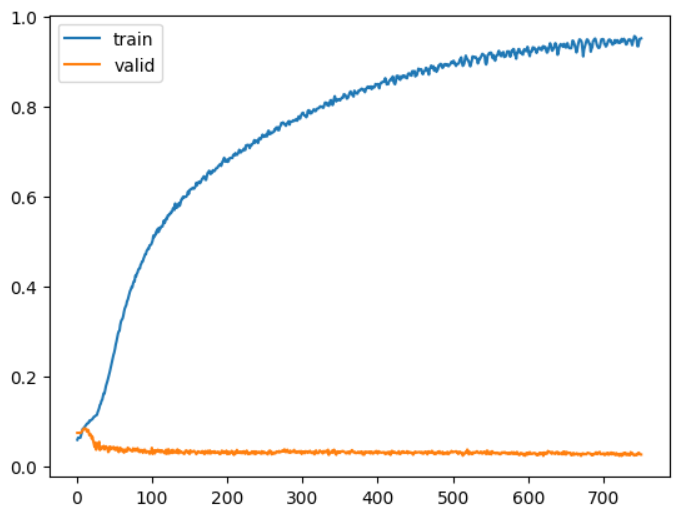


50 EPOCHS:
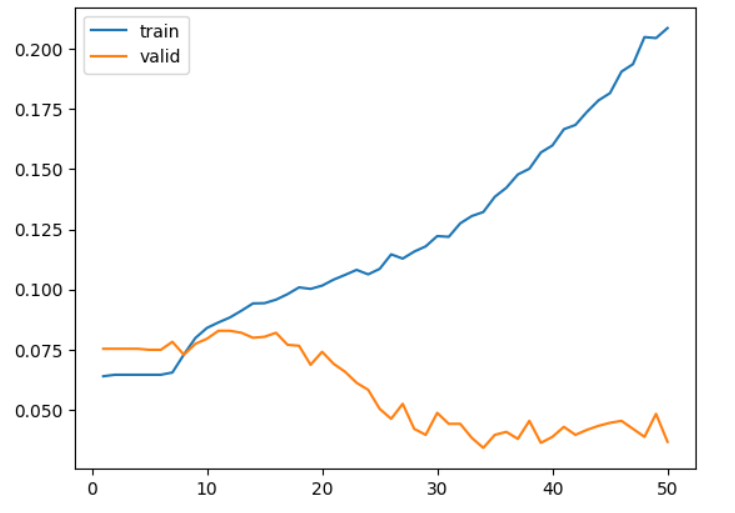

Es importante otras tecnicas de embedding para texto, vemos que apesar de usar 50 epochs y obtener un buen resutaldo, puede parecer sin sentido por el accuracy de validación, nos dice que el modelo solo predice bien con datos de entrenamiento.